# Jun 2nd, 2022 (prune finalized -- almost)

**Motivation**: Increasing kmeans n_init helps.  For prune: no great insight, but probably have to use different threshold for bold and ca.  But definitely we need prune, otherwise there is a lot of junk in there <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.group import *
from utils.render import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
def quick_show(
    data,
    vmin=0.1,
    vmax=None,
    figsize=None,
    cmap='magma',
    ylabel_fontsize=11.5,
    show: bool = True, ):
    num = max(len(tr['proj-top']) for tr in data.values())
    figsize = figsize if figsize else (13.5, 1.6 * len(data))
    fig, axes = create_figure(
        nrows=len(data),
        ncols=num,
        figsize=figsize,
        tight_layout=False,
        constrained_layout=False,
        reshape=True,
    )
    for i, (lbl, tr) in enumerate(data.items()):
        for j in range(num):
            ax = axes[i, j]
            if j >= len(tr['proj-top']):
                ax.remove()
            else:
                ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
                if np.nanmax(tr['proj-top'][j]) > 1:
                    _cmap = get_cluster_cmap(range(len(tr['proj-top']) - 1))
                    _vmax = None
                else:
                    _cmap = cmap
                    _vmax = vmax
                ax.imshow(
                    mwh(tr['proj-top'][j] < vmin, tr['proj-top'][j]),
                    cmap=_cmap, vmin=vmin, vmax=_vmax,
                )
                if j == 0:
                    ax.set_ylabel(lbl, fontsize=ylabel_fontsize)
    remove_ticks(axes)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, axes


In [3]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
task = 'rest'
band_ca = (0.01, 0.5)
mice.setup_func_data(task, band_ca=band_ca)

num_k, p = 10, 20
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()

pr_ca = gr_ca.prune(thres=0.003, ci=0.95, n_resamples=int(1e3))

pi = bn.nanmean(gr_ca.run_pi, -3)
pi_pr = bn.nanmean(pr_ca['pi_prune_run'], -3)

h = sp_stats.entropy(pi, axis=-2) / np.log(gr_ca.num_k)
h_pr = sp_stats.entropy(pi_pr, axis=-2) / np.log(gr_ca.num_k)

In [6]:
pr_ca['votes']['votes'].sum() / (pr_ca['votes']['votes'].sum() + (~pr_ca['votes']['votes']).sum())

0.5086842105263157

In [7]:
pr_ca['votes']['num_zeroed'] / (pr_ca['votes']['num_accepted'] + pr_ca['votes']['num_zeroed'])

0.4987919463087248

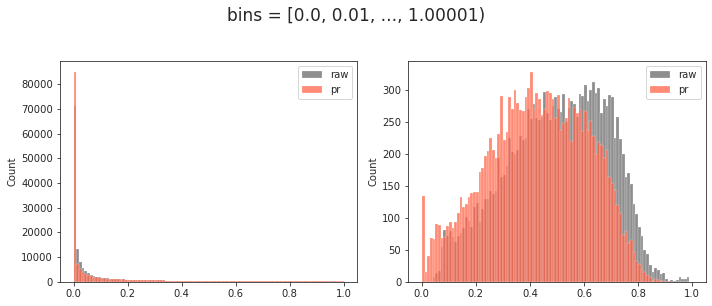

In [8]:
fig, axes = create_figure(1, 2, (10, 4))

bins = np.linspace(0, 1, 101)
bins[-1] += 1e-5

sns.histplot(
    pi[np.isfinite(pi)],
    bins=bins,
    color='dimgrey',
    label='raw',
    ax=axes[0],
)
sns.histplot(
    pi_pr[np.isfinite(pi_pr)],
    bins=bins,
    color='tomato',
    label='pr',
    ax=axes[0],
)
sns.histplot(
    h[np.isfinite(h)],
    bins=bins,
    color='dimgrey',
    label='raw',
    ax=axes[1],
)
sns.histplot(
    h_pr[np.isfinite(h_pr)],
    bins=bins,
    color='tomato',
    label='pr',
    ax=axes[1],
)
for ax in axes.flat:
    ax.legend()
fig.suptitle(f"bins = [{bins[0]}, {bins[1]}, ..., {max(bins)})", fontsize=17, y=1.05)
plt.show()

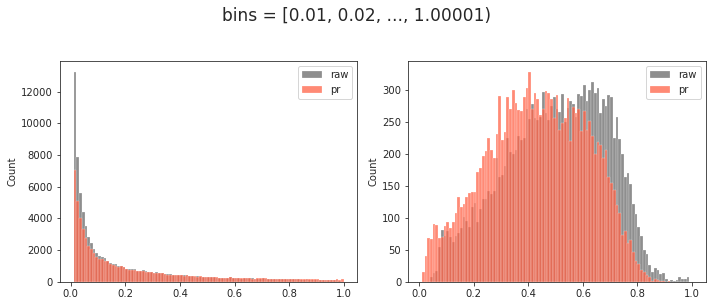

In [9]:
fig, axes = create_figure(1, 2, (10, 4))

bins = np.linspace(0.01, 1, 100)
bins[-1] += 1e-5

sns.histplot(
    pi[np.isfinite(pi)],
    bins=bins,
    color='dimgrey',
    label='raw',
    ax=axes[0],
)
sns.histplot(
    pi_pr[np.isfinite(pi_pr)],
    bins=bins,
    color='tomato',
    label='pr',
    ax=axes[0],
)
sns.histplot(
    h[np.isfinite(h)],
    bins=bins,
    color='dimgrey',
    label='raw',
    ax=axes[1],
)
sns.histplot(
    h_pr[np.isfinite(h_pr)],
    bins=bins,
    color='tomato',
    label='pr',
    ax=axes[1],
)
for ax in axes.flat:
    ax.legend()
fig.suptitle(f"bins = [{bins[0]}, {bins[1]}, ..., {max(bins)})", fontsize=17, y=1.05)
plt.show()

### This was a good answer

In [10]:
aligned_new, centroids = gr_ca.align_post_prune(pr_ca['pi_prune_run'])
aligned_new_avg = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(aligned_new, 3), 2), 1), 0)
centroids /= np.nansum(centroids, -2, keepdims=True)
gr_ca.avg()

In [11]:
gr_ca.fit_meta

{
    'time_start': '2022_06_03_15-57',
    'min_runs_thresh': 0.6,
    'min_node_thresh': 0.7,
    'best_node_freq_q': 0.93,
    'num_total_runs': 110,
    'fraction_accepted_runs': 0.6727272727272727,
    'fraction_good_nodes': 0.7368421052631579,
    'time_end': '2022_06_03_15-59'
}

In [12]:
perf = ''
a, b = gr_ca.pi_symmetry_score(decimals=4)
perf += f"raw  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(pr_ca['pi_prune_avg'], decimals=4)
perf += f"pr  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(aligned_new_avg, decimals=4)
perf += f"pr+algn\t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
print(perf)

raw     .  .  . ovp: 0.9854, disj:  0.9658
pr      .  .  . ovp: 0.9818, disj:  0.9632
pr+algn .  .  . ovp: 0.9823, disj:  0.9632

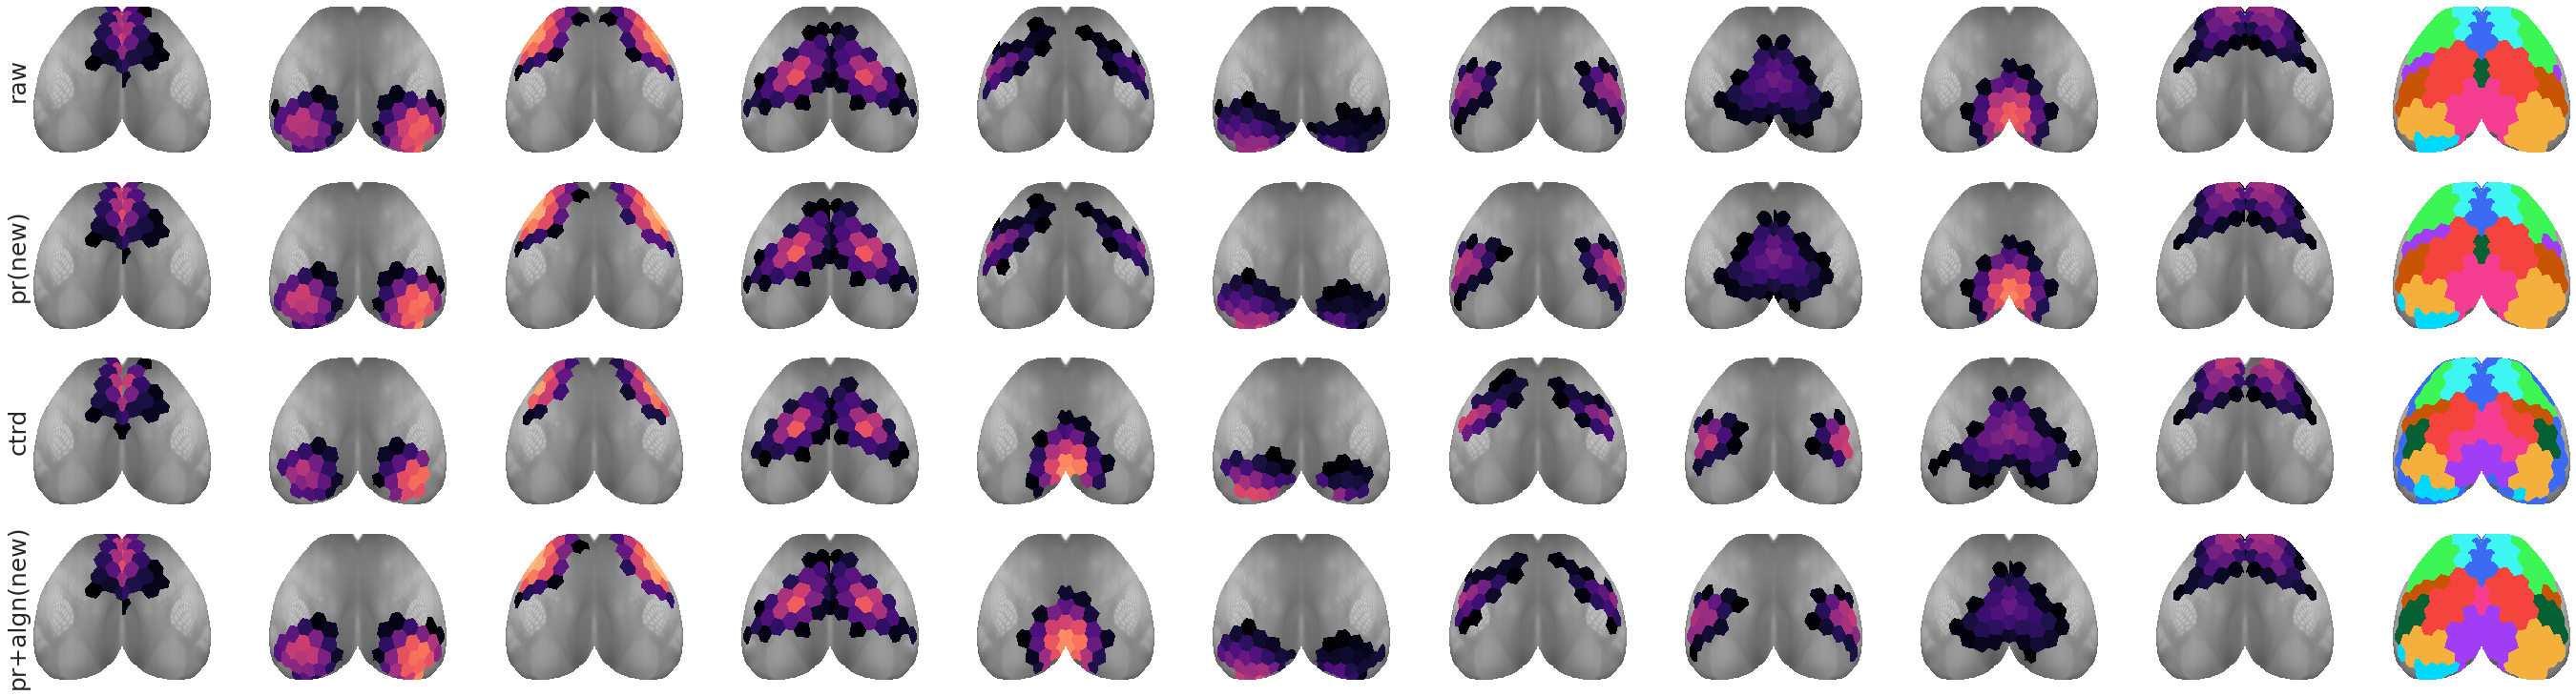

In [13]:
d2p = {
    'raw': gr_ca.trim2d(gr_ca.project_vec()),
    'pr(new)': gr_ca.trim2d(gr_ca.project_vec(pr_ca['pi_prune_avg'])),
    'ctrd': gr_ca.trim2d(gr_ca.project_vec(centroids)),
    'pr+algn(new)': gr_ca.trim2d(gr_ca.project_vec(aligned_new_avg)),
}
_ = quick_show(d2p, vmax=1.0, figsize=(48, 13), ylabel_fontsize=25)

raw     .  .  . ovp: 0.9869, disj:  0.9763
pr      .  .  . ovp: 0.9828, disj:  0.9842
pr+algn .  .  . ovp: 0.9831, disj:  0.9763

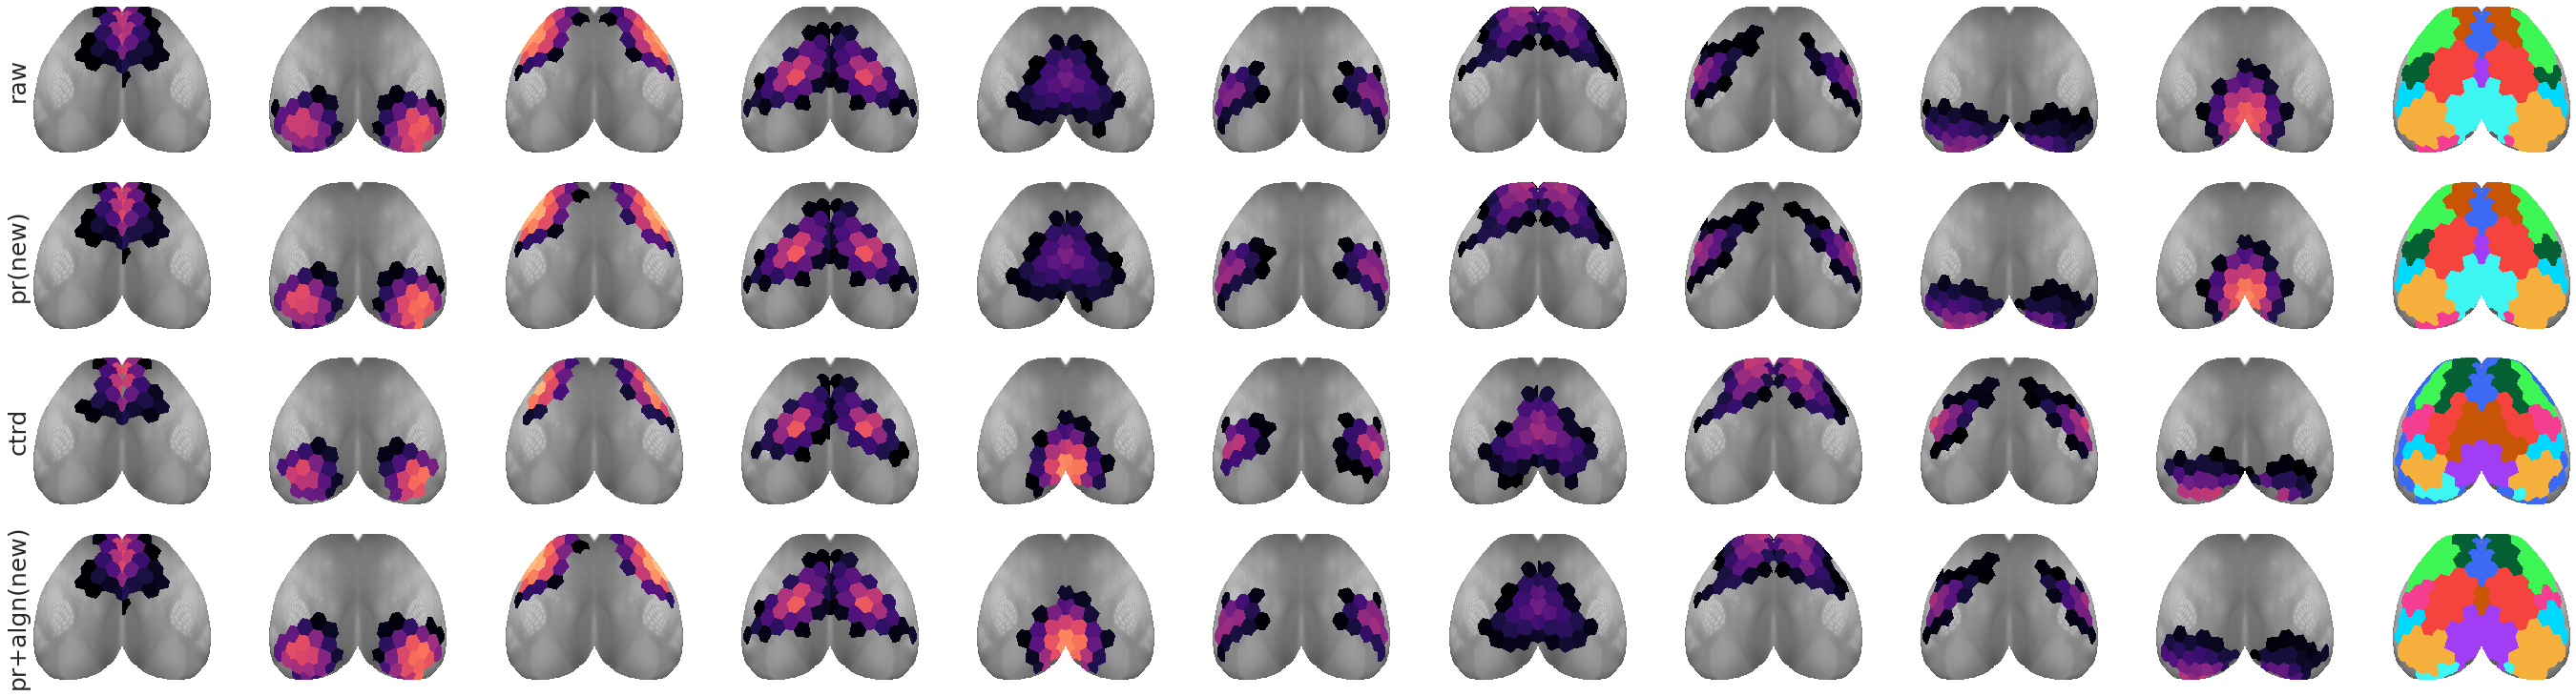

#### Fewer seeds?

In [16]:
aligned_new_avg = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
    aligned_new[..., :115, :, :], 3), 2), 1), 0)

perf = ''
a, b = gr_ca.pi_symmetry_score(decimals=4)
perf += f"raw  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(pr_ca['pi_prune_avg'], decimals=4)
perf += f"pr  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(aligned_new_avg, decimals=4)
perf += f"pr+algn\t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
print(perf)

raw     .  .  . ovp: 0.9854, disj:  0.9658
pr      .  .  . ovp: 0.9818, disj:  0.9632
pr+algn .  .  . ovp: 0.9820, disj:  0.9737

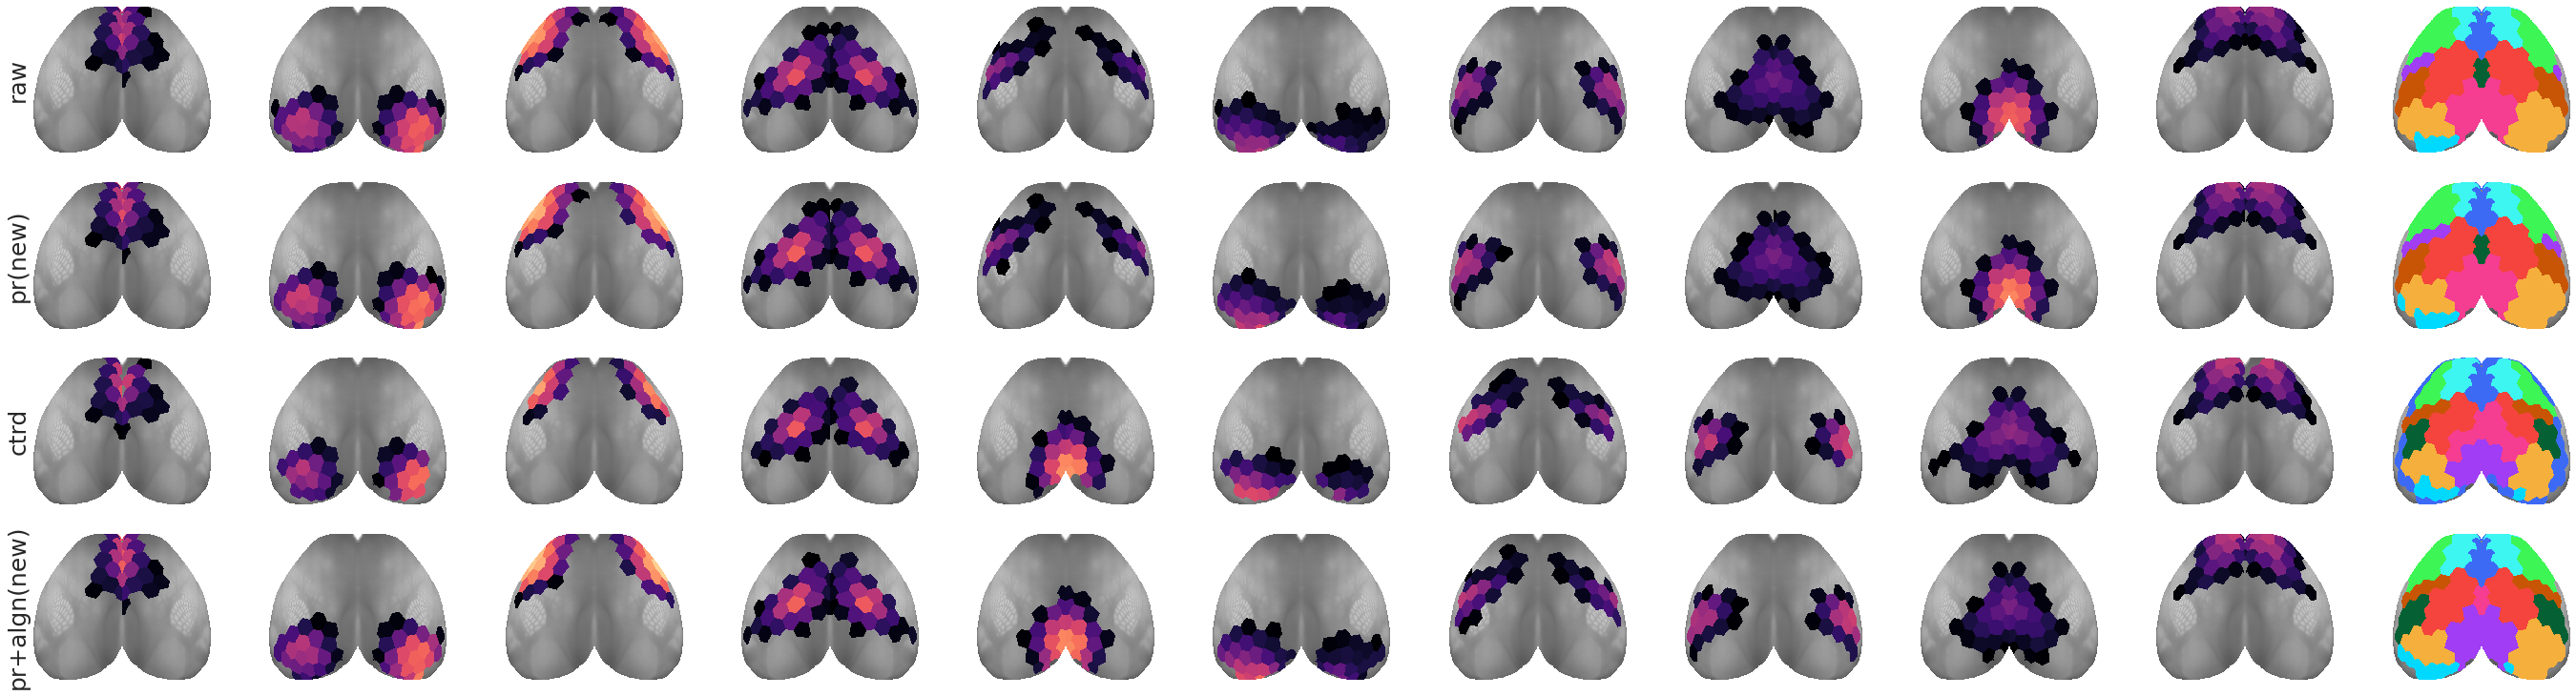

In [17]:
d2p = {
    'raw': gr_ca.trim2d(gr_ca.project_vec()),
    'pr(new)': gr_ca.trim2d(gr_ca.project_vec(pr_ca['pi_prune_avg'])),
    'ctrd': gr_ca.trim2d(gr_ca.project_vec(centroids)),
    'pr+algn(new)': gr_ca.trim2d(gr_ca.project_vec(aligned_new_avg)),
}
_ = quick_show(d2p, vmax=1.0, figsize=(48, 13), ylabel_fontsize=25)

### Now experiment with different kws

In [20]:
gr_ca.kw_kmeans

{'n_init': 100, 'max_iter': 300, 'tol': 0.0001}

In [28]:
gr_ca.kw_kmeans = {
    'n_init': 100,
    'max_iter': 500,
    'tol': 1e-8,
}
aligned_new, centroids = gr_ca.align_post_prune(pr_ca['pi_prune_run'])
aligned_new_avg = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
    aligned_new, 3), 2), 1), 0)
centroids /= np.nansum(centroids, -2, keepdims=True)
gr_ca.avg()

raw     .  .  . ovp: 0.9854, disj:  0.9658
pr      .  .  . ovp: 0.9818, disj:  0.9632
pr+algn .  .  . ovp: 0.9821, disj:  0.9605

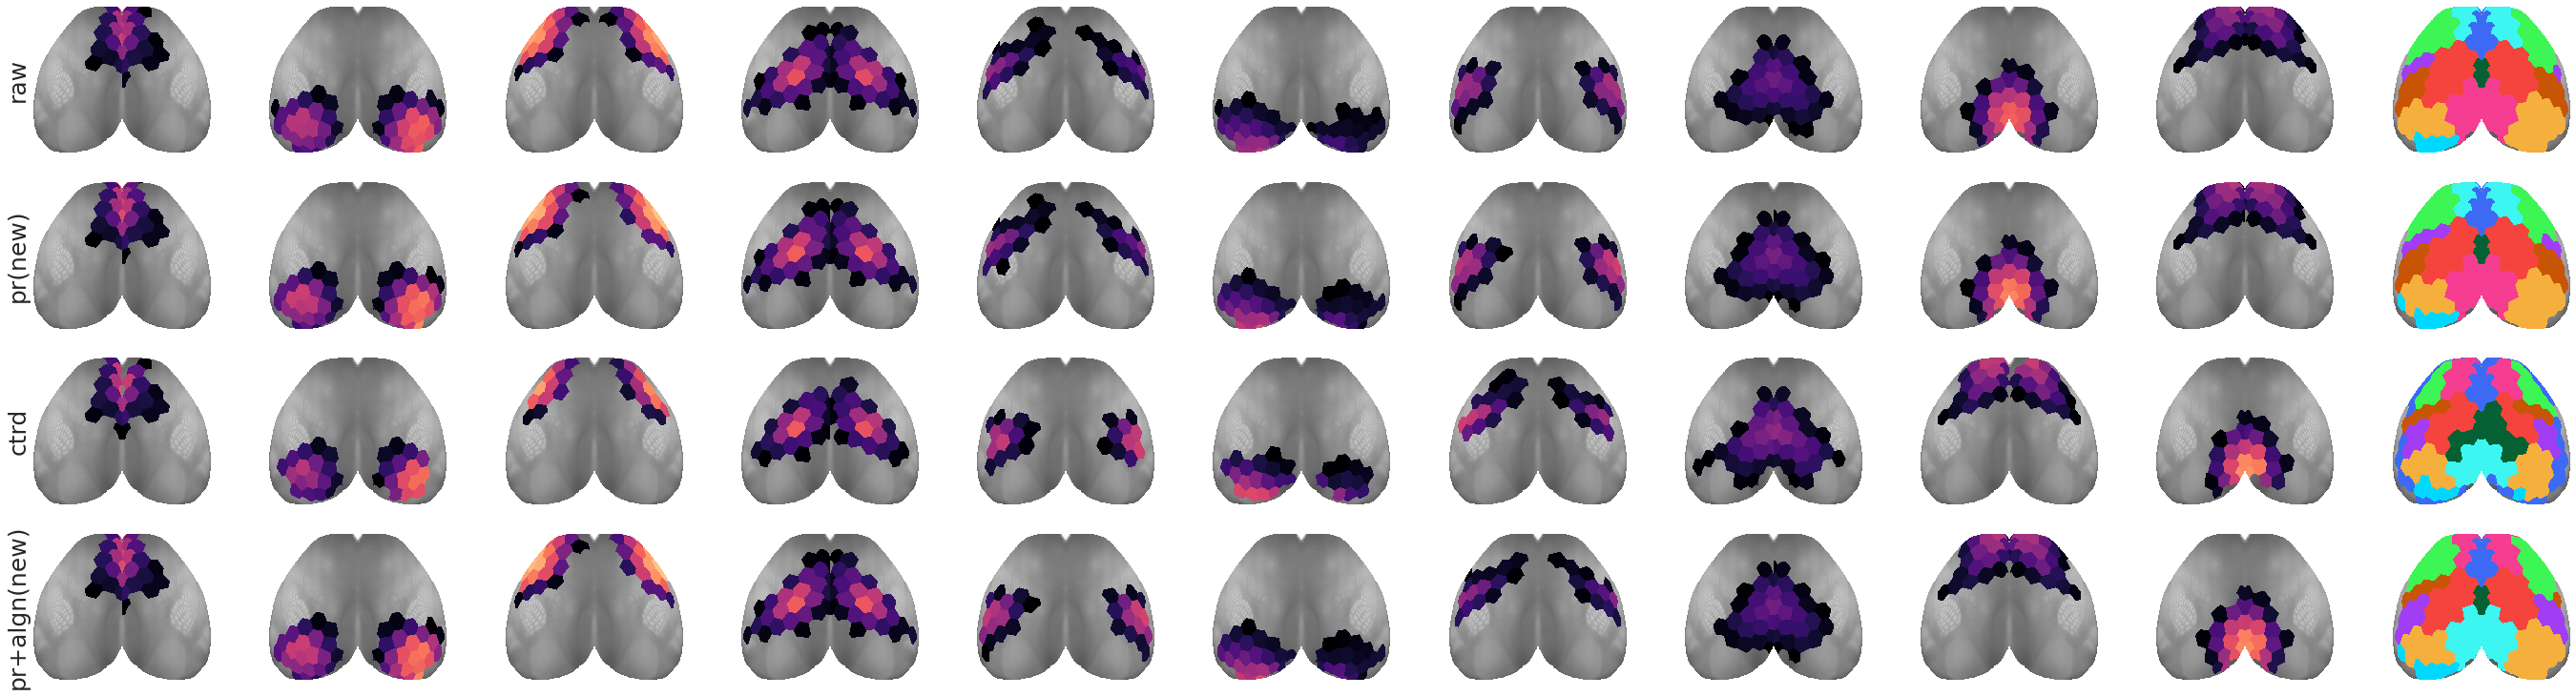

In [29]:
perf = ''
a, b = gr_ca.pi_symmetry_score(decimals=4)
perf += f"raw  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(pr_ca['pi_prune_avg'], decimals=4)
perf += f"pr  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(aligned_new_avg, decimals=4)
perf += f"pr+algn\t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
print(perf)

d2p = {
    'raw': gr_ca.trim2d(gr_ca.project_vec()),
    'pr(new)': gr_ca.trim2d(gr_ca.project_vec(pr_ca['pi_prune_avg'])),
    'ctrd': gr_ca.trim2d(gr_ca.project_vec(centroids)),
    'pr+algn(new)': gr_ca.trim2d(gr_ca.project_vec(aligned_new_avg)),
}
_ = quick_show(d2p, vmax=1.0, figsize=(48, 13), ylabel_fontsize=25)

In [30]:
gr_ca.kw_kmeans

{'n_init': 100, 'max_iter': 500, 'tol': 1e-08}

raw     .  .  . ovp: 0.9869, disj:  0.9763
pr      .  .  . ovp: 0.9828, disj:  0.9842
pr+algn .  .  . ovp: 0.9832, disj:  0.9763

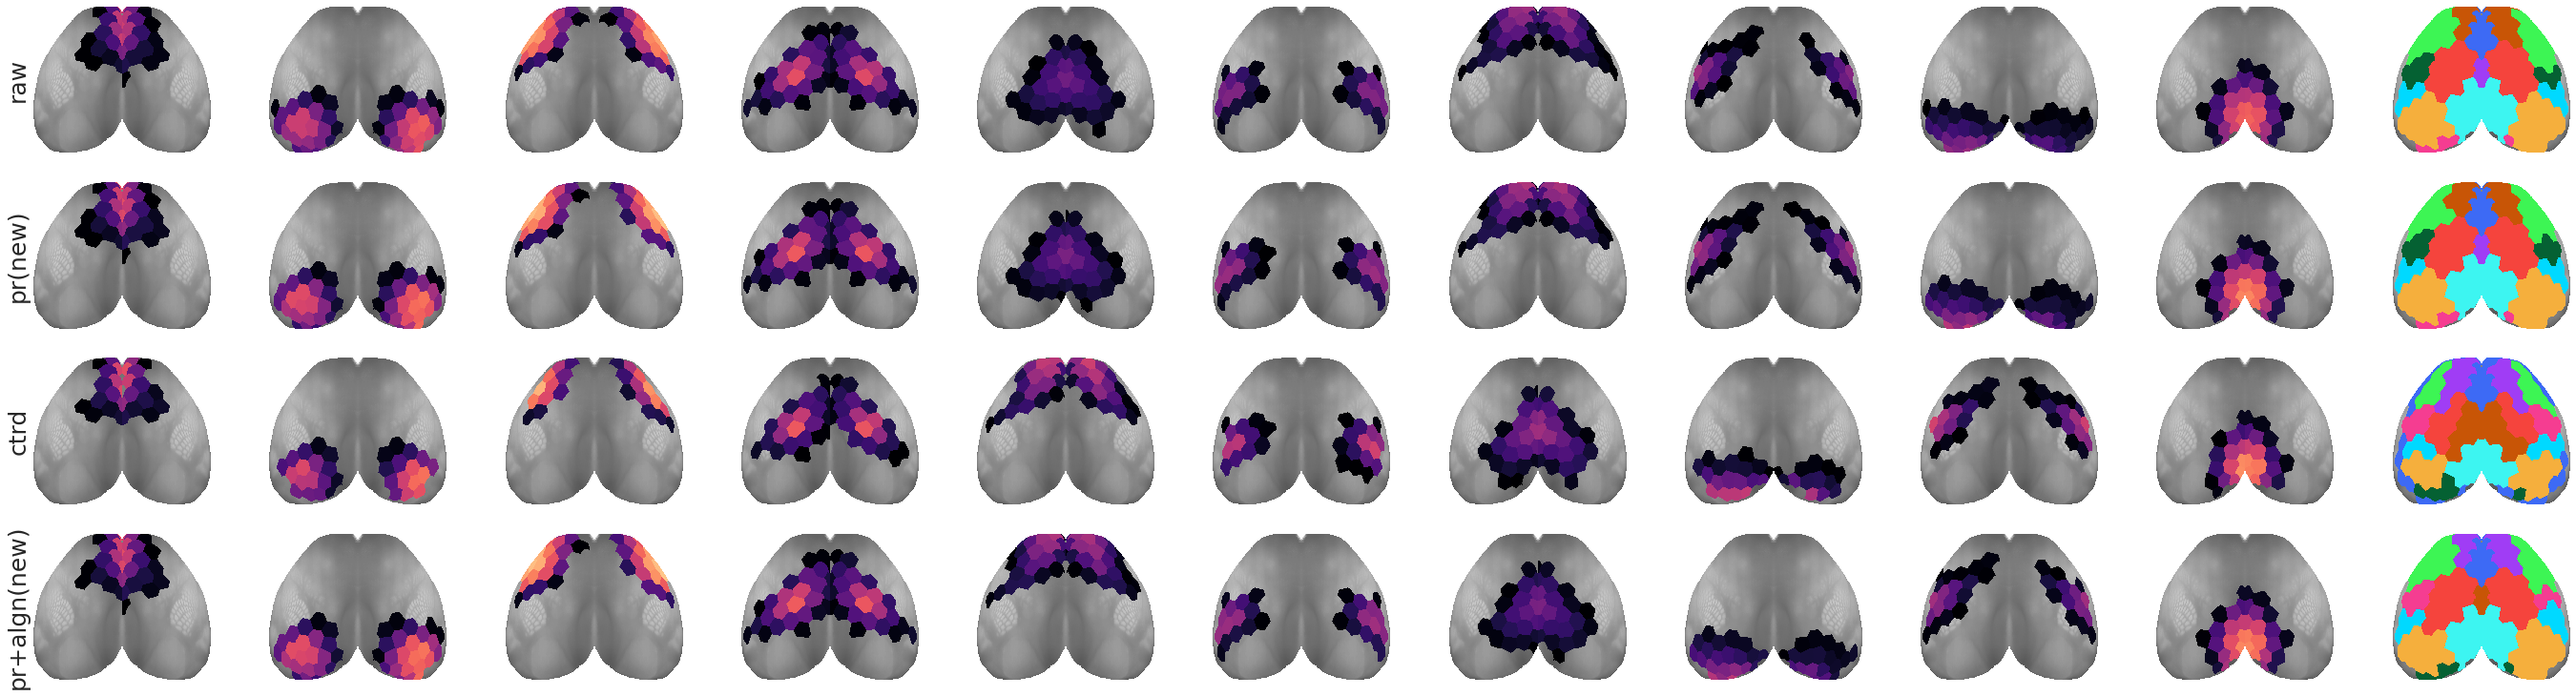

In [8]:
hist, bin_edges = np.histogram(h_pr[np.isfinite(h_pr)], bins=100)
len(hist), len(bin_edges)

(100, 101)

[<matplotlib.lines.Line2D object at 0x7fd4a1b65ca0>]

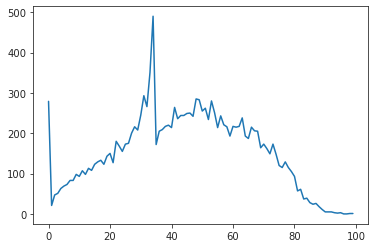

In [9]:
plt.plot(hist)

In [10]:
maxes = np.argsort(hist)[::-1][:10]
maxes

array([34, 33, 31, 48, 49, 53,  0, 32, 41, 51])

In [11]:
i_max = 34

In [12]:
bin_edges[i_max], bin_edges[i_max + 1]

(0.29531555429025297, 0.3040013058870251)

In [13]:
ids = list(zip(*np.where(np.logical_and(bin_edges[i_max] <= h_pr, h_pr < bin_edges[i_max + 1]))))
len(ids)

490

In [14]:
ids[:5]

[(0, 0, 0, 9), (0, 0, 0, 19), (0, 0, 0, 37), (0, 0, 0, 83), (0, 0, 0, 85)]

<AxesSubplot:ylabel='Count'>

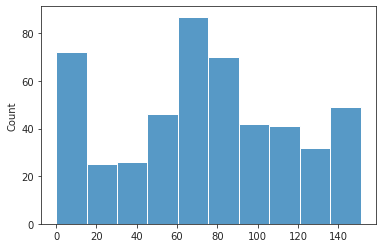

In [15]:
sns.histplot([nn for i, j, k, nn in ids])

In [45]:
i, j, k, nn = ids[0]

In [46]:
pi_pr.shape

(10, 3, 4, 10, 152)

<AxesSubplot:ylabel='Count'>

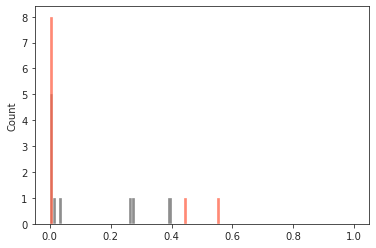

In [48]:
sns.histplot(pi[i, j, k, :, nn], bins=np.linspace(0, 1, 101), color='dimgrey')
sns.histplot(pi_pr[i, j, k, :, nn], bins=np.linspace(0, 1, 101), color='tomato')

In [49]:
pi[i, j, k, :, nn]

array([0.03841579, 0.00142857, 0.27222752, 0.00740019, 0.00142857,
       0.01184148, 0.3944328 , 0.00144086, 0.26995564, 0.00142857])

In [50]:
pi_pr[i, j, k, :, nn]

array([0.        , 0.        , 0.44900629, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.55099371, 0.        ])

In [51]:
np.round(pi[i, j, k, :, nn], 2)

array([0.04, 0.  , 0.27, 0.01, 0.  , 0.01, 0.39, 0.  , 0.27, 0.  ])

In [52]:
gr_ca.run_pi[i, j, k, ..., nn].shape

(250, 10)

In [53]:
bad_seeds = np.where(np.isnan(gr_ca.run_pi[i, j, k, ..., nn]).sum(1) == 10)[0]
x = np.delete(gr_ca.run_pi[i, j, k, ..., nn], bad_seeds, axis=0)

<AxesSubplot:ylabel='Count'>

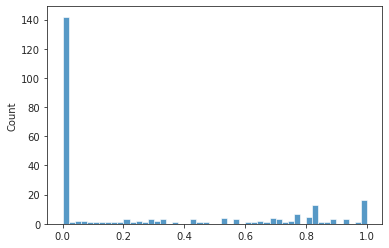

In [54]:
sns.histplot(x[:, 8], bins=np.linspace(0, 1, 51))

In [55]:
seeds_a = np.where(x[:, 8] < 0.002)[0]
seeds_b = np.where(x[:, 8] > 0.98)[0]
len(seeds_a), len(seeds_b)

(142, 16)

In [152]:
np.argmin(x[:, 8]), np.argmax(x[:, 8])

(89, 226)

In [155]:
np.round(x[89], 2)

array([0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [156]:
np.round(x[226], 2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ])

In [159]:
a = gr_ca.run_pi[i, j, k][89]
b = gr_ca.run_pi[i, j, k][226]

In [160]:
tra = gr_ca.project_vec(a)
trb = gr_ca.project_vec(b)
tra = gr_ca.trim2d(tra)
trb = gr_ca.trim2d(trb)

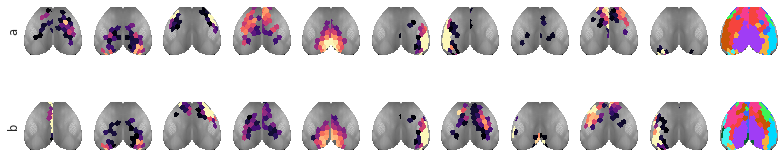

In [162]:
_ = quick_show({'a': tra, 'b': trb}, vmax=1.0)

In [321]:
gr_ca.run_pi.shape

(10, 3, 4, 250, 10, 152)

In [322]:
%%time

dims = {'sub': 10, 'ses': 3, 'run': 4, 'seed': 250}
b_anim = bootstrap(
    x=gr_ca.run_pi,
    n_resamples=int(1e3),
    batch=5,
    skip=['sub'],
    dims=dims,
    est=bn.nanmean,
    est_axis=-3,
)
b_anim = bn.nanmean(bn.nanmean(b_anim, 3), 2)
b_anim.shape

CPU times: user 3min 10s, sys: 1min 43s, total: 4min 53s
Wall time: 4min 53s


(1000, 10, 10, 152)

In [323]:
se_anim = np.nanstd(b_anim, axis=0, ddof=1)

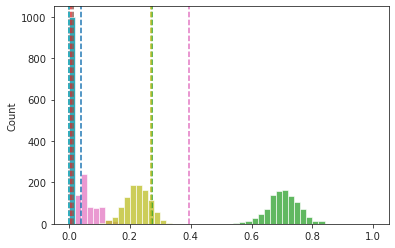

In [324]:
for kk in range(10):
    sns.histplot(b_anim[:, i, kk, nn], bins=np.linspace(0, 1, 51), color=f'C{kk}')
    plt.axvline(pi[i, j, k, kk, nn], color=f'C{kk}', ls='--')

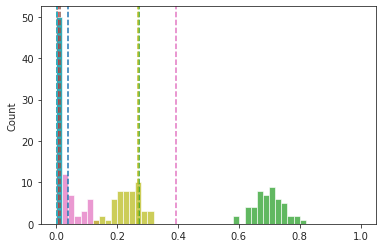

In [325]:
np.round(pi[i, j, k, :, nn], 2)

array([0.04, 0.  , 0.27, 0.01, 0.  , 0.01, 0.39, 0.  , 0.27, 0.  ])

In [328]:
np.round(bn.nanmean(b_anim, 0)[i][..., nn], 2)

array([0.01, 0.  , 0.7 , 0.  , 0.  , 0.  , 0.05, 0.  , 0.22, 0.  ])

In [329]:
np.round(bn.nanmean(gr_ca.run_pi[i, j, k, ..., nn], 0), 2)

array([0.04, 0.  , 0.27, 0.01, 0.  , 0.01, 0.39, 0.  , 0.27, 0.  ])

In [343]:
aaa = np.round(bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
    gr_ca.run_pi[..., nn], 3), 2), 1), 0), 2)
aaa

array([0.03, 0.  , 0.71, 0.  , 0.  , 0.01, 0.04, 0.  , 0.2 , 0.01])

In [344]:
sp_stats.entropy(aaa) / np.log(10)

0.3870045359819519

In [345]:
aaa[aaa < 0.05] = 0
aaa /= np.sum(aaa)
aaa

array([0.        , 0.        , 0.78021978, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.21978022, 0.        ])

In [346]:
sp_stats.entropy(aaa) / np.log(10)

0.22871235196577525

In [350]:
bbb = bn.nanmean(bn.nanmean(bn.nanmean(pi_pr, 2), 1), 0)[:, nn]
bbb

array([0.01158059, 0.        , 0.75821579, 0.        , 0.        ,
       0.        , 0.0101491 , 0.        , 0.22005453, 0.        ])

In [351]:
sp_stats.entropy(bbb) / np.log(10)

0.27847825830999656

In [ ]:
sp_stats.entropy(np.round(bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(
    gr_ca.run_pi[..., nn], 3), 2), 1), 0), 2))

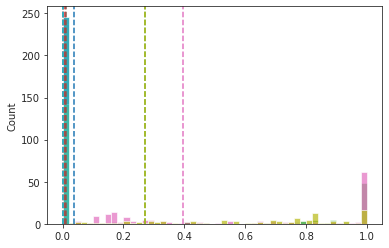

In [312]:
for kk in range(10):
    sns.histplot(gr_ca.run_pi[i, j, k, ..., kk, nn], bins=np.linspace(0, 1, 51), color=f'C{kk}')
    plt.axvline(pi[i, j, k, kk, nn], color=f'C{kk}', ls='--')

<matplotlib.lines.Line2D object at 0x7f3b54b77fd0>

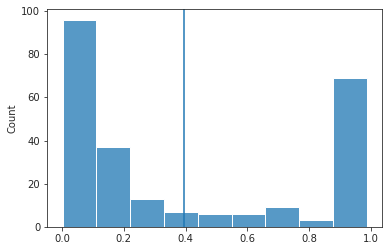

In [315]:
kk = 6
sns.histplot(gr_ca.run_pi[i, j, k, ..., kk, nn])
plt.axvline(bn.nanmean(gr_ca.run_pi[i, j, k, ..., kk, nn]))

## Finalize below

In [3]:
mice = Mice(128)

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

In [4]:
task = 'rest'
band_ca = (0.01, 0.5)
mice.setup_func_data(task, band_ca=band_ca)

num_k, p = 10, 20
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
gr_ca = Group(**props_ca).fit_group()
pr_ca = gr_ca.prune(n_resamples=int(7e3))

pi = bn.nanmean(gr_ca.run_pi, -3)
pi_pr = pr_ca['pi_prune_run'].copy()
h = sp_stats.entropy(pi, axis=-2) / np.log(gr_ca.num_k)
h_pr = sp_stats.entropy(pi_pr, axis=-2) / np.log(gr_ca.num_k)

In [7]:
i1, i2, i3, i4, num_k, num_n = gr_ca.run_pi.shape
dims = {'sub': i1, 'ses': i2, 'run': i3, 'seed': i4}

In [8]:
%%time

b_anim = bootstrap(
    x=gr_ca.run_pi,
    dims=dims,
    skip=['sub'],
    n_resamples=int(1e3),
    batch=5,
    est=bn.nanmean,
    est_axis=-3,
)
b_anim = bn.nanmean(bn.nanmean(b_anim, 3), 2)
b_anim.shape

CPU times: user 3min 4s, sys: 1min 41s, total: 4min 45s
Wall time: 4min 46s


(1000, 10, 10, 152)

In [9]:
se_anim = np.nanstd(b_anim, axis=0, ddof=1)

In [99]:
pi_anim = bn.nanmean(bn.nanmean(pi, 2), 1)
i, j, k, kk, nn = pi.shape

votes = np.zeros((nn, i, kk))

thres = 0.003
ci = 0.95

In [100]:
for anim in range(i):
    n_missing = pi[anim].reshape(-1, kk, nn)
    n_missing = np.isnan(n_missing).mean(1).mean(1)
    n_missing = (n_missing == 1).sum()
    dof = j * k - n_missing - 1
    t_val = sp_stats.t.ppf(ci, dof)
    looper = itertools.product(
        range(nn), range(kk))
    for node, oc in looper:
        mu = pi_anim[anim, oc, node]
        se = se_anim[anim, oc, node]
        lower = mu - t_val * se
        if np.isnan(lower):
            votes[node, anim, oc] = np.nan
        elif lower <= thres:
            votes[node, anim, oc] = 1

votes = votes.astype(bool)

In [101]:
votes.sum() / ((~votes).sum() + votes.sum())

0.5105921052631579

In [105]:
votes_dict = {'votes': votes.astype(bool)}

In [179]:
zeroed_vals = []
looper = itertools.product(
    range(nn), range(i))
for node, anim in looper:
    vote = votes_dict['votes'][node, anim]
    zeroed_vals.extend(list(gr_ca.run_pi[anim, ..., node].reshape(-1, gr_ca.num_k)[:, vote].ravel()))

zeroed_vals = np.array(zeroed_vals)
zeroed_vals = zeroed_vals[np.isfinite(zeroed_vals)]
len(zeroed_vals)

17367294

In [183]:
np.max(zeroed_vals)

0.9879194630872491

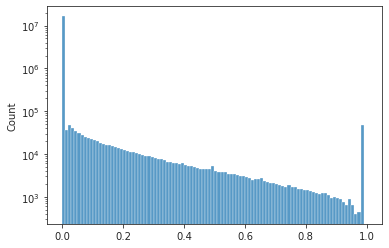

In [187]:
sns.histplot(zeroed_vals, bins=np.linspace(0, 1, 101))
plt.yscale('log')

In [189]:
pi_prune = gr_ca.run_pi.copy()

looper = itertools.product(
    range(nn), range(i))
for node, anim in looper:
    vote = votes_dict['votes'][node, anim]
    vote = vote.reshape(1, 1, 1, -1).astype(bool)
    vote = np.repeat(vote, j, axis=0)
    vote = np.repeat(vote, k, axis=1)
    vote = np.repeat(vote, 250, axis=2)
    pi_prune[anim, ..., node][vote] = 0.

pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune.shape

(10, 3, 4, 250, 10, 152)

In [190]:
pi_pr_avg = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 3), 2), 1), 0)

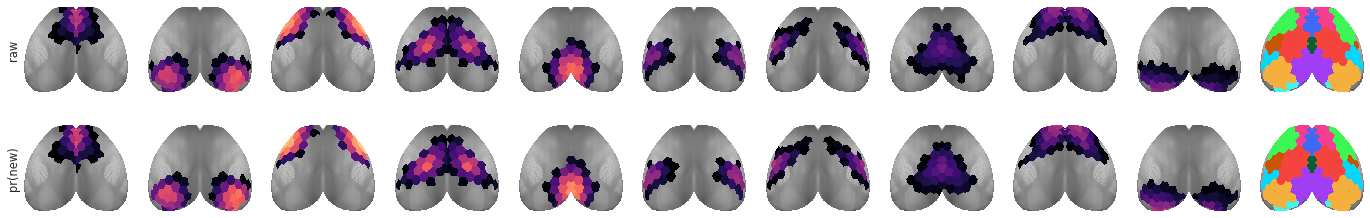

In [192]:
d2p = {
    'raw': gr_ca.trim2d(gr_ca.project_vec()),
    'pr(new)': gr_ca.trim2d(gr_ca.project_vec(pi_pr_avg)),
}
_ = quick_show(d2p, vmax=1.0, figsize=(24, 4))

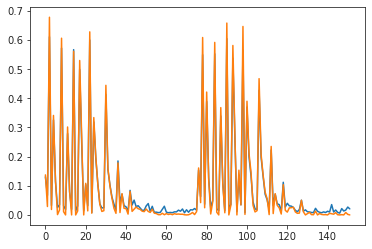

In [194]:
plt.plot(gr_ca.pi[0])
plt.plot(pi_pr_avg[0]);

### new Kmeans using pruned pi

In [ ]:
def align_post_prune(self, pi: np.ndarray = None):
    pi = pi if pi is not None else self.run_pi
    accepted_runs, good_global = self._good_nodes(bn.nanmean(pi, -3))
    
    data = []
    for ii, jj, kk in accepted_runs:
        x = pi_prune[ii, jj, kk]
        bad_seeds = np.isnan(x).sum(-1).sum(-1) == gr_ca.num_k * len(gr_ca.n2l)
        data.append(x[~bad_seeds].reshape(-1, len(gr_ca.n2l)))
    data = np.concatenate(data)

In [211]:
pi_prune.shape

(10, 3, 4, 250, 10, 152)

In [212]:
accepted_runs, good_global = gr_ca._good_nodes(bn.nanmean(pi_prune, -3), 0.90)
len(accepted_runs), len(good_global)

(64, 118)

True

In [288]:
good_global

array([  4,   5,   7,   8,   9,  11,  12,  13,  16,  17,  18,  19,  20,
        21,  22,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  38,  39,  40,  41,  42,  43,  45,  46,  47,  48,  49,
        50,  51,  52,  54,  55,  56,  57,  58,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  71,  73,  80,  81,  83,  84,  85,  87,
        88,  89,  92,  93,  94,  95,  96,  97,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131,
       132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       147])

In [225]:
data = []
for ii, jj, kk in accepted_runs:
    x = pi_prune[ii, jj, kk]
    bad_seeds = np.isnan(x).sum(-1).sum(-1) == gr_ca.num_k * len(gr_ca.n2l)
    data.append(x[~bad_seeds].reshape(-1, len(gr_ca.n2l)))
data = np.concatenate(data)
data.shape

(148400, 152)

In [226]:
nonan = np.where(np.isnan(data).sum(0) == 0)[0]
centroids = np.zeros((gr_ca.num_k, data.shape[-1]))

In [227]:
len(nonan)

118

In [229]:
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=self.num_k,
    match_metric=self.sv_props['match_metric'],
    random_state=self.mice.cfg.random_state,
)
centroids[:, nonan] = _centroids

In [230]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    metric='cosine',
    global_order=False,
)
centroids = centroids[global_mapping]

In [231]:
centroids /= np.nansum(centroids, -2, keepdims=True)

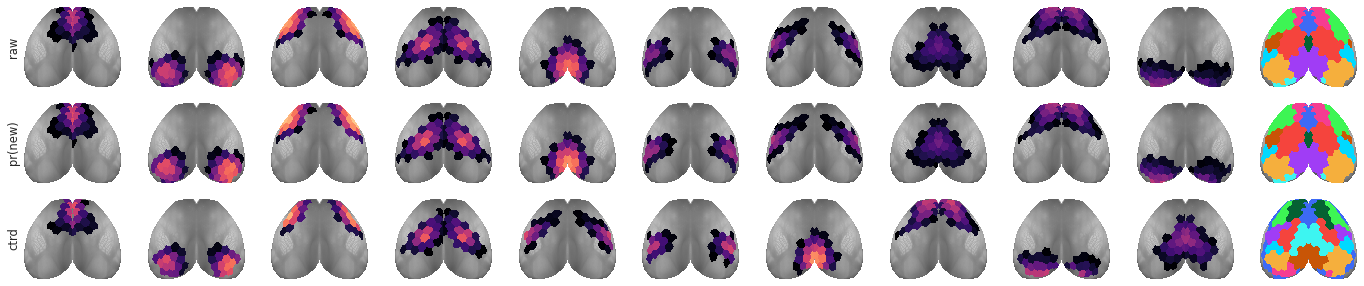

In [233]:
d2p = {
    'raw': gr_ca.trim2d(gr_ca.project_vec()),
    'pr(new)': gr_ca.trim2d(gr_ca.project_vec(pi_pr_avg)),
    'ctrd': gr_ca.trim2d(gr_ca.project_vec(centroids)),
}
_ = quick_show(d2p, vmax=1.0, figsize=(24, 5))

In [234]:
pi_prune.shape

(10, 3, 4, 250, 10, 152)

In [256]:
%%time

perms = {}
ner = Normalizer()
for ii, jj, kk in itertools.product(range(10), range(3), range(4)):
    x = pi_prune[ii, jj, kk]
    bad_seeds = np.isnan(x).sum(-1).sum(-1) == gr_ca.num_k * len(gr_ca.n2l)
    if bad_seeds.sum() == len(x):
        continue
    x = x[~bad_seeds]
    good = np.where(np.isnan(x).sum(0).sum(0) == 0)[0]
    good = set(good).intersection(good_global)
    good = np.array(sorted(good))
    
    _x = x[..., good]
    _x = np.where(~np.isnan(_x), _x, 0.0)
    data2align = {
        i: ner.fit_transform(v)
        for i, v in enumerate(_x)
    }
    perms[(ii, jj, kk)] = find_best_mappings(
        data=data2align,
        centroids=ner.fit_transform(centroids[:, good]),
        match_metric=self.align_metric,
        global_order=self.global_order,
    )

CPU times: user 11.1 s, sys: 9.29 ms, total: 11.1 s
Wall time: 11.1 s


In [291]:
aligned_new = np_nans(pi_prune.shape)
for ii, jj, kk in itertools.product(range(10), range(3), range(4)):
    gmap_dict = perms.get((ii, jj, kk))
    if not gmap_dict:
        continue
    for seed, gmap in gmap_dict.items():
        aligned_new[ii, jj, kk, seed] = pi_prune[ii, jj, kk, seed][list(gmap.values())]
aligned_new.shape

(10, 3, 4, 250, 10, 152)

(10, 152)

In [57]:
pr_ca['pi_prune_run'].shape

(10, 3, 4, 250, 10, 152)

In [59]:

aligned_new.shape

(10, 3, 4, 250, 10, 152)

In [16]:
aligned_new, centroids = gr_ca.align_post_prune(pr_ca['pi_prune_run'])
aligned_new_avg = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(aligned_new, 3), 2), 1), 0)
centroids /= np.nansum(centroids, -2, keepdims=True)
gr_ca.avg()
d2p = {
    'raw': gr_ca.trim2d(gr_ca.project_vec()),
    'pr(new)': gr_ca.trim2d(gr_ca.project_vec(pr_ca['pi_prune_avg'])),
    'ctrd': gr_ca.trim2d(gr_ca.project_vec(centroids)),
    'pr+algn(new)': gr_ca.trim2d(gr_ca.project_vec(aligned_new_avg)),
}

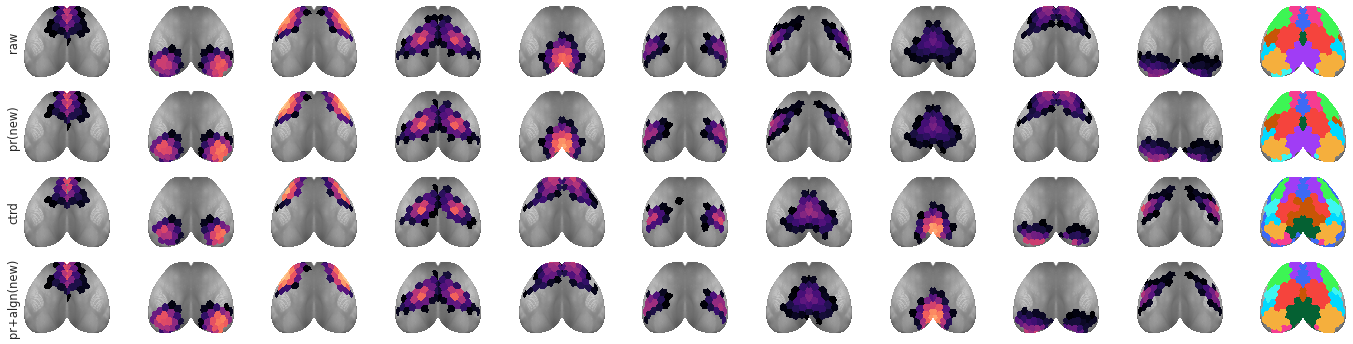

In [17]:
_ = quick_show(d2p, vmax=1.0, figsize=(24, 6))

In [31]:
perf = ''
a, b = gr_ca.pi_symmetry_score(decimals=4)
perf += f"raw  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(pr_ca['pi_prune_avg'], decimals=4)
perf += f"pr  \t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"
a, b = gr_ca.pi_symmetry_score(aligned_new_avg, decimals=4)
perf += f"pr+algn\t.  .  .\tovp: {a[-1]:0.4f}, disj:  {b[-1]:0.4f}\n"

print(perf)

raw     .  .  . ovp: 0.9869, disj:  0.9684
pr      .  .  . ovp: 0.9818, disj:  0.9737
pr+algn .  .  . ovp: 0.9822, disj:  0.9737

(0.9818, 0.9737)

In [20]:
a, b = gr_ca.pi_symmetry_score(aligned_new_avg, decimals=4)
a[-1], b[-1]

(0.9822, 0.9737)

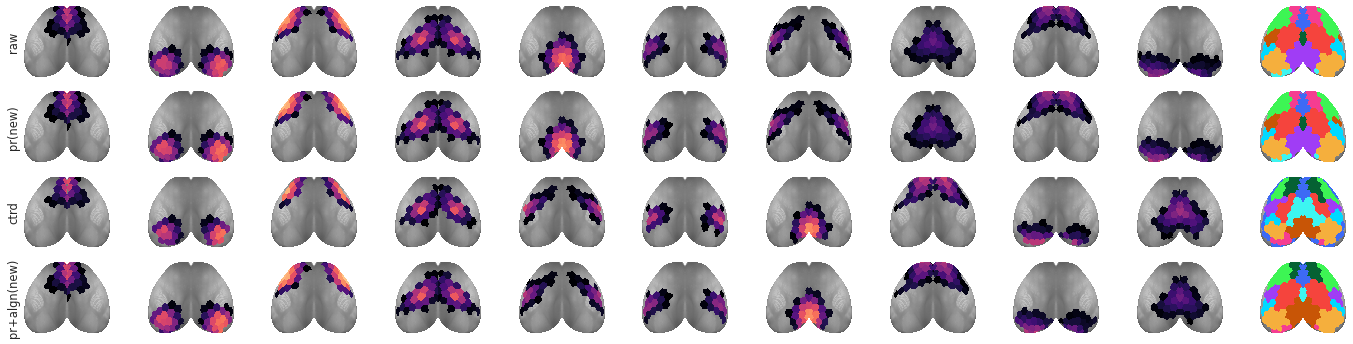

In [293]:
d2p = {
    'raw': gr_ca.trim2d(gr_ca.project_vec()),
    'pr(new)': gr_ca.trim2d(gr_ca.project_vec(pi_pr_avg)),
    'ctrd': gr_ca.trim2d(gr_ca.project_vec(centroids)),
    'pr+algn(new)': gr_ca.trim2d(gr_ca.project_vec(aligned_new_avg)),
}
_ = quick_show(d2p, vmax=1.0, figsize=(24, 6))

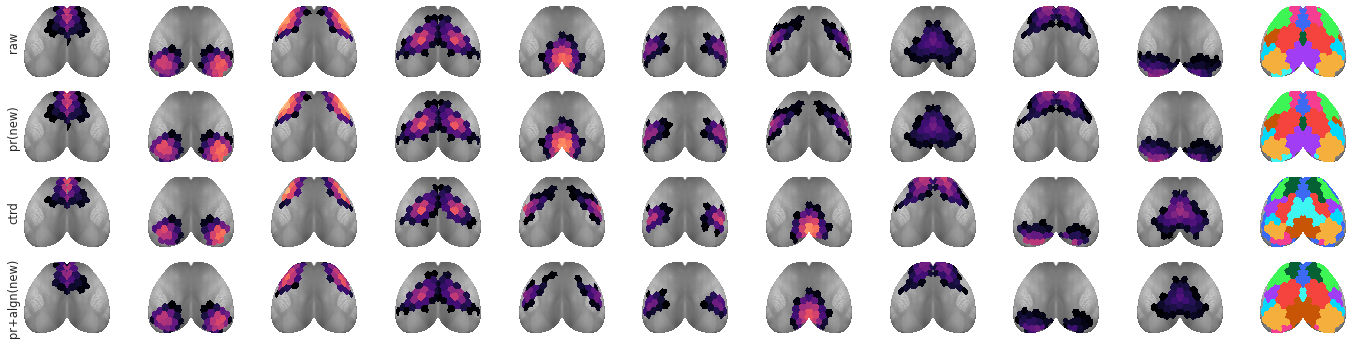

In [69]:
a, b = gr_ca.pi_symmetry_score(decimals=4)
a[-1], b[-1]

(0.9869, 0.9684)

In [70]:
a, b = gr_ca.pi_symmetry_score(pr_ca['pi_prune_avg'], decimals=4)
a[-1], b[-1]

(0.9836, 0.9737)

In [71]:
a, b = gr_ca.pi_symmetry_score(aligned_new_avg, decimals=4)
a[-1], b[-1]

(0.9838, 0.9763)

In [294]:
gr_ca.pi_symmetry_score()

(
    {
        1: 0.992,
        2: 0.974,
        3: 0.993,
        4: 0.993,
        5: 0.998,
        6: 0.991,
        7: 0.988,
        8: 0.992,
        9: 0.987,
        10: 0.961,
        -1: 0.987
    },
    {
        1: 1.0,
        2: 0.934,
        3: 0.934,
        4: 0.974,
        5: 1.0,
        6: 0.987,
        7: 0.947,
        8: 1.0,
        9: 0.961,
        10: 0.947,
        -1: 0.968
    }
)

In [297]:
gr_ca.pi_symmetry_score(pi_pr_avg)

(
    {
        1: 0.991,
        2: 0.966,
        3: 0.993,
        4: 0.992,
        5: 0.997,
        6: 0.99,
        7: 0.99,
        8: 0.989,
        9: 0.987,
        10: 0.941,
        -1: 0.984
    },
    {
        1: 1.0,
        2: 0.934,
        3: 0.961,
        4: 0.987,
        5: 1.0,
        6: 0.974,
        7: 0.961,
        8: 1.0,
        9: 0.974,
        10: 0.947,
        -1: 0.974
    }
)

In [298]:
gr_ca.pi_symmetry_score(aligned_new_avg)

(
    {
        1: 0.992,
        2: 0.966,
        3: 0.993,
        4: 0.992,
        5: 0.99,
        6: 0.988,
        7: 0.997,
        8: 0.987,
        9: 0.943,
        10: 0.989,
        -1: 0.984
    },
    {
        1: 1.0,
        2: 0.947,
        3: 0.961,
        4: 1.0,
        5: 0.974,
        6: 0.987,
        7: 1.0,
        8: 0.974,
        9: 0.947,
        10: 1.0,
        -1: 0.979
    }
)

In [277]:
h = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_pr = sp_stats.entropy(pi_prune, axis=-2) / np.log(gr_ca.num_k)
h_aligned_new = sp_stats.entropy(aligned_new, axis=-2) / np.log(gr_ca.num_k)

<AxesSubplot:ylabel='Count'>

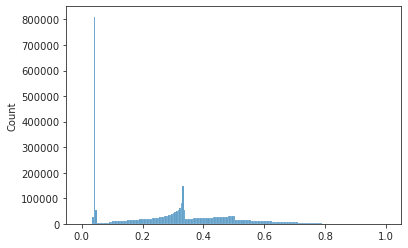

In [284]:
sns.histplot(h[np.isfinite(h)], bins=np.linspace(0, 1, 201))

<AxesSubplot:ylabel='Count'>

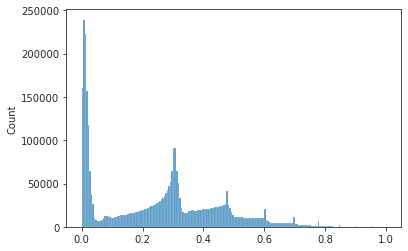

In [285]:
sns.histplot(h_pr[np.isfinite(h_pr)], bins=np.linspace(0, 1, 201))

<AxesSubplot:ylabel='Count'>

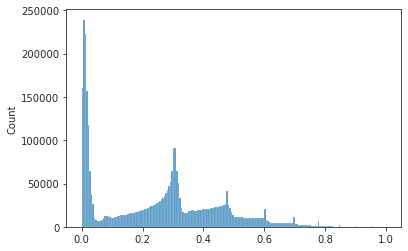

In [286]:
sns.histplot(h_aligned_new[np.isfinite(h_aligned_new)], bins=np.linspace(0, 1, 201))

<AxesSubplot:ylabel='Count'>

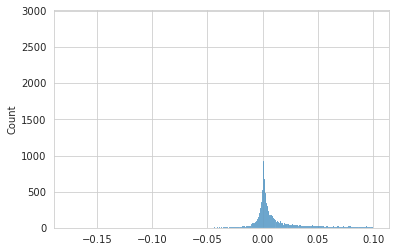

In [38]:
sns.histplot(lower_vals[lower_vals < 0.1])

In [45]:
lower_vals.shape

(10, 10, 152)

In [48]:
a, b, c = list(zip(*np.where(lower_vals == np.nanmin(lower_vals)))).pop()
a, b, c

(8, 9, 76)

In [49]:
pi[a, ..., b, c]

array([[       nan, 0.79359558, 0.00255474,        nan],
       [0.00162684, 0.00236053, 0.017697  , 0.00246047],
       [       nan,        nan,        nan,        nan]])

<AxesSubplot:ylabel='Count'>

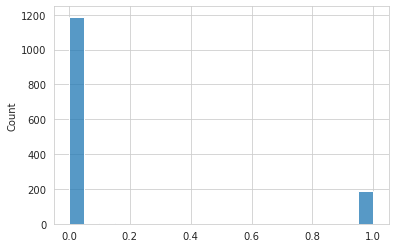

In [56]:
sns.histplot(
    gr_ca.run_pi[a, ..., b, c][np.isfinite(gr_ca.run_pi[a, ..., b, c])],
    bins=np.linspace(0, 1, 21),
)

<AxesSubplot:ylabel='Count'>

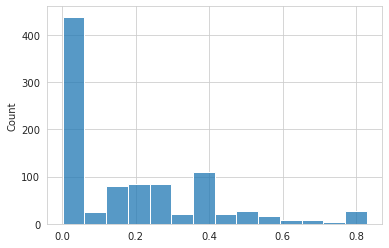

In [59]:
sns.histplot(b_anim[:, a, b, c])

{
    'sub-SLC01': 12,
    'sub-SLC02': 10,
    'sub-SLC03': 10,
    'sub-SLC04': 10,
    'sub-SLC05': 10,
    'sub-SLC06': 12,
    'sub-SLC07': 11,
    'sub-SLC08': 11,
    'sub-SLC09': 12,
    'sub-SLC10': 12
}

In [ ]:
votes_dict = self.cast_votes(
    se_anim=se_anim,
    pi_run=pi,
    thres=thres,
    ci=ci,
)

## H

In [130]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
gr_ca.run_pi = pr_ca['pi_prune_run']
gr_ca.pi = pr_ca['pi_prune_avg']

h_ca_10 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_10, 2), 1), 0)
gr_ca.num_k

10

In [ ]:
"""b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
props_ca['num_k'] += 1
gr_ca = Group(**props_ca).fit_group()
gr_ca.avg()

pr_ca = gr_ca.prune(n_resamples=int(7e3))
gr_ca.run_pi = pr_ca['pi_prune_run']
gr_ca.pi = pr_ca['pi_prune_avg']

h_ca_11 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_11 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_11, 2), 1), 0)
gr_ca.num_k"""

In [131]:
props_bo = {'mode': 'bold-lite', **props_base}
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
# _ = gr_bo._merge_vis(0.05)

h_bo_10 = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_10, 2), 1), 0)
gr_bo.num_k

10

In [8]:
props_bo = {'mode': 'bold-lite', **props_base}
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
# _ = gr_bo._merge_vis(0.05)

h_bo_11 = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_11 = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_11, 2), 1), 0)
gr_bo.num_k

11

In [11]:
props_bo = {'mode': 'bold-lite', **props_base}
props_bo['num_k'] += 1
gr_bo = Group(**props_bo).fit_group()
pr_bo = gr_bo.prune(n_resamples=int(7e3), ci=0.95)
gr_bo.run_pi = pr_bo['pi_prune_run']
gr_bo.pi = pr_bo['pi_prune_avg']
_ = gr_bo._merge_vis(0.05)

h_bo_mg = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(gr_bo.num_k)
h_avg_bo_mg = bn.nanmean(bn.nanmean(bn.nanmean(h_bo_mg, 2), 1), 0)
gr_bo.num_k

10

In [136]:
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)
props_ca = {'mode': 'ca2', **props_base}
gr_ca = Group(**props_ca).fit_group()
gr_ca.run_pi = bn.nanmean(gr_ca.run_pi, -3)

h_ca_10 = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(gr_ca.num_k)
h_avg_ca_10 = bn.nanmean(bn.nanmean(bn.nanmean(h_ca_10, 2), 1), 0)
gr_ca.num_k

10

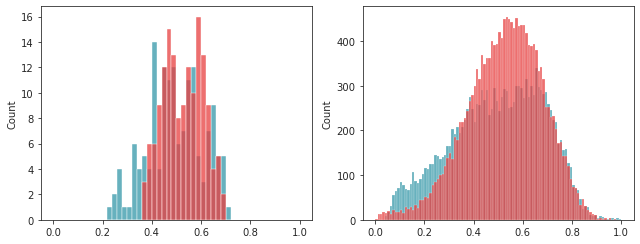

In [138]:
fig, axes = create_figure(1, 2, (9, 3.5))

sns.histplot(h_avg_ca_10, bins=np.linspace(0, 1, 51), color=pal['ca2'], ax=axes[0])
sns.histplot(h_avg_bo_10, bins=np.linspace(0, 1, 51), color=pal['bold-lite'], ax=axes[0])

sns.histplot(h_ca_10[h_ca_10.nonzero()], bins=np.linspace(0, 1, 101), color=pal['ca2'], ax=axes[1])
sns.histplot(h_bo_10[h_bo_10.nonzero()], bins=np.linspace(0, 1, 101), color=pal['bold-lite'], ax=axes[1])

plt.show()

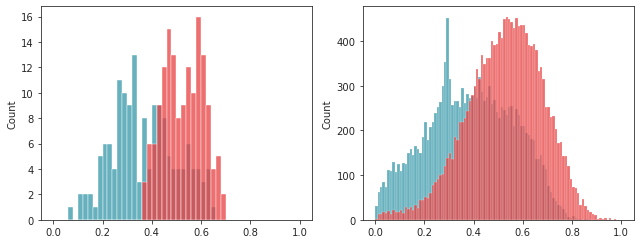

In [161]:
gr_ca.avg()
d2p[f'ca2(not-pr)\nb={b}'.replace(' ', '')] = gr_ca.trim2d(gr_ca.project_vec())

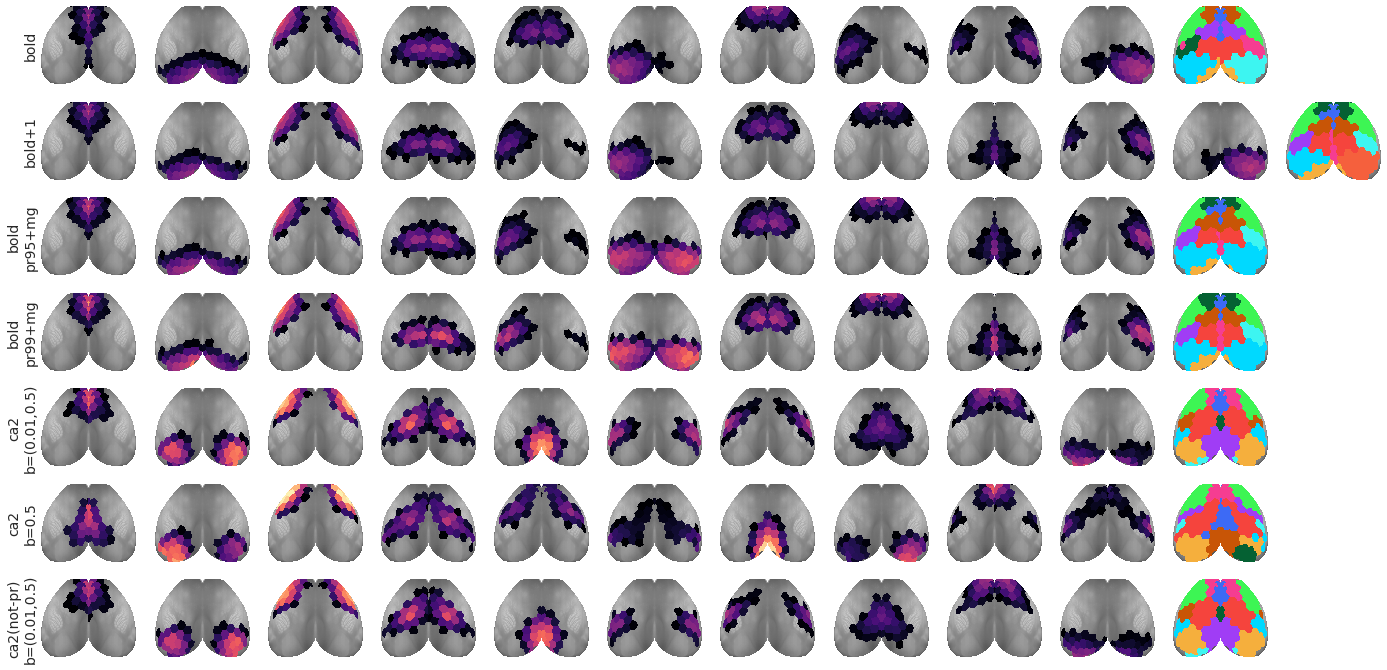

In [162]:
_ = quick_show(d2p, vmin=0.1, vmax=1.0, figsize=(24, 12), ylabel_fontsize=14)

<AxesSubplot:ylabel='Count'>

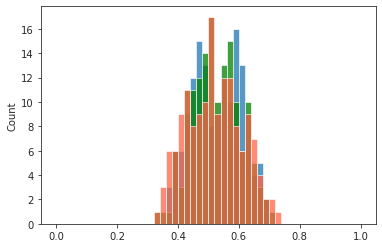

In [139]:
sns.histplot(h_avg_bo_10, bins=np.linspace(0, 1, 51))
sns.histplot(h_avg_bo_11, bins=np.linspace(0, 1, 51), color='g')
sns.histplot(h_avg_bo_mg, bins=np.linspace(0, 1, 51), color='tomato')

In [163]:
trh_ca_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_ca_10, add_disjoint=False))
trh_bo_10 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_10, add_disjoint=False))
trh_bo_11 = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_11, add_disjoint=False))
trh_bo_mg = gr_ca.trim2d(gr_bo.project_vec(h_avg_bo_mg, add_disjoint=False))

vmin = min(np.nanmin(h_avg_ca_10), np.nanmin(h_avg_bo_10), np.nanmin(h_avg_bo_11), np.nanmin(h_avg_bo_mg))
vmax = max(np.nanmax(h_avg_ca_10), np.nanmax(h_avg_bo_10), np.nanmax(h_avg_bo_11), np.nanmax(h_avg_bo_mg))
kw_im = {
    'vmin': vmin,
    'vmax': vmax,
    'cmap': 'icefire',
}
vmin, vmax

(0.23037689538563905, 0.724035911433707)

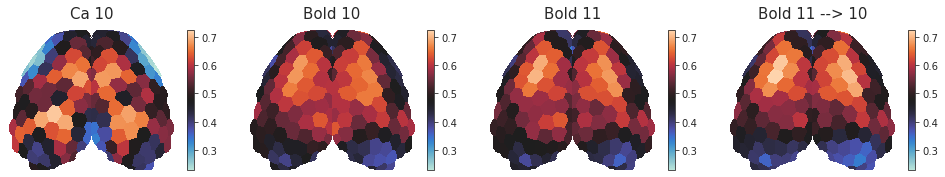

In [141]:
fig, axes = create_figure(1, 4, (13.5, 2.4))

im = axes[0].imshow(mwh(trh_ca_10['proj-top'][0] < vmin, trh_ca_10['proj-top'][0]), **kw_im)
axes[0].set_title('Ca 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(mwh(trh_bo_10['proj-top'][0] < vmin, trh_bo_10['proj-top'][0]), **kw_im)
axes[1].set_title('Bold 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(mwh(trh_bo_11['proj-top'][0] < vmin, trh_bo_11['proj-top'][0]), **kw_im)
axes[2].set_title('Bold 11', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[2])

im = axes[3].imshow(mwh(trh_bo_mg['proj-top'][0] < vmin, trh_bo_mg['proj-top'][0]), **kw_im)
axes[3].set_title('Bold 11 --> 10', fontsize=15, y=1.04)
plt.colorbar(im, ax=axes[3])

remove_ticks(axes)
plt.show()

In [142]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_mg)

(0.9207048579946774, 3.561061905557345e-63)

In [143]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_bo_11)

(0.9580061746150019, 2.8609405138619793e-83)

In [144]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_bo_11)

(0.9634534518516699, 1.045062568998126e-87)

In [147]:
sp_stats.pearsonr(h_avg_bo_10, h_avg_ca_10)

(0.4332918165008459, 2.4652039288401117e-08)

In [148]:
sp_stats.pearsonr(h_avg_bo_mg, h_avg_ca_10)

(0.3801225500857732, 1.3629250608234312e-06)

### Conclusion: for entropy do not use mg, mg is just for visualization of communities
- For other statistics also do not use mg, just find out how to cut data from say num k = 11 and then somehow average the two communities to be mg-ed and that gives u a single number for that community

## Difference map

### ca_10 vs bo_10

In [149]:
y1 = h_bo_10.reshape(-1, h_bo_10.shape[-1])
y2 = h_ca_10.reshape(-1, h_ca_10.shape[-1])
y1.shape, y2.shape

((120, 152), (120, 152))

In [150]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [151]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [152]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

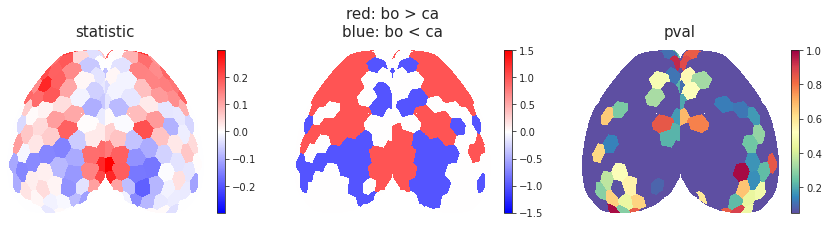

In [155]:
fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue['proj-top'][0] > alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

### ca_10 vs bo_mg

In [156]:
y1 = h_bo_mg.reshape(-1, h_bo_mg.shape[-1])
y2 = h_ca_10.reshape(-1, h_ca_10.shape[-1])
y1.shape, y2.shape

((120, 152), (120, 152))

In [157]:
def statistic(a, b, axis):
    return bn.nanmean(a - b, axis=axis)

In [158]:
test = sp_stats.permutation_test(
    data=(y1, y2),
    statistic=statistic,
    permutation_type='samples',
    alternative='two-sided',
    n_resamples=int(1e3),
    vectorized=True,
    random_state=42,
    batch=5,
    axis=0,
)

In [159]:
tr_statistic = gr_ca.project_vec(test.statistic, add_disjoint=False, thres=-np.inf)
tr_pvalue = gr_ca.project_vec(test.pvalue, add_disjoint=False, thres=-np.inf)
tr_statistic = gr_ca.trim2d(tr_statistic)
tr_pvalue = gr_ca.trim2d(tr_pvalue)

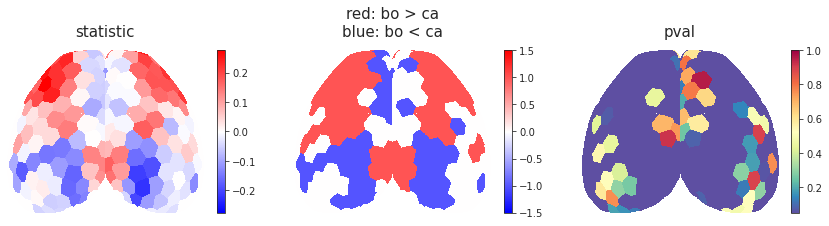

In [160]:
fig, axes = create_figure(1, 3, (12, 3))

alpha = 0.05

vminmax = np.max(np.abs(test.statistic))
im = axes[0].imshow(
    mwh(tr_statistic['top'] == 0, tr_statistic['proj-top'][0]),
    cmap='bwr', vmin=-vminmax, vmax=vminmax)
axes[0].set_title('statistic', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[0])

x = tr_statistic['proj-top'][0].copy()
x[x > 0] = 1
x[x < 0] = -1
x[tr_pvalue['proj-top'][0] > alpha] = 0
im = axes[1].imshow(
    mwh(tr_pvalue['top'] == 0.0, x),
    cmap='bwr', vmin=-1.5, vmax=1.5)
axes[1].set_title('red: bo > ca\nblue: bo < ca', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(
    mwh(tr_pvalue['top'] == 0, tr_pvalue['proj-top'][0]),
    cmap='Spectral_r', vmin=alpha, vmax=1)
axes[2].set_title('pval', fontsize=15, y=1.05)
plt.colorbar(im, ax=axes[2])

remove_ticks(axes)
plt.show()

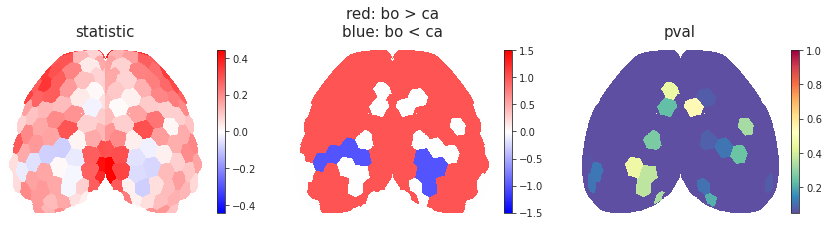

In [56]:
from statsmodels.stats.multitest import multipletests

<AxesSubplot:>

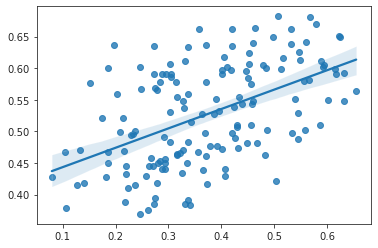

In [116]:
sns.regplot(h_avg_ca_10, h_avg_bo_10)

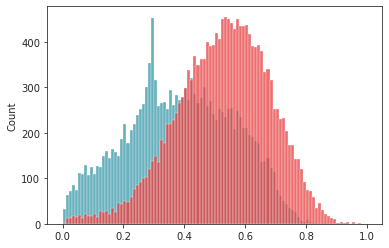